# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable

# Data Preparation

In [2]:
# Transform the data to torch tensors and normalize it 
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(
                                 (0.5, ), (0.5, ))])

# Prepare training set and testing set
trainset = torchvision.datasets.MNIST('mnist', train=True, 
                                       download=True,
                                      transform=transform)
testset = torchvision.datasets.MNIST('mnist', train = False,
                                       download=True,
                                     transform=transform)

# Prepare training loader and testing loader
train_loader = torch.utils.data.DataLoader(trainset,
                                           batch_size = 100,
                                          shuffle = True,
                                           num_workers=0)
test_loader = torch.utils.data.DataLoader(testset,
                                          batch_size = 100,
                                         shuffle = False,
                                          num_workers=0) 

In [3]:
print(trainset.data.shape)
print(testset.data.shape)


torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [7]:
data_iter = iter(train_loader)
images, labels = data_iter.next()

print(images.shape)
print(labels.shape)

torch.Size([100, 1, 28, 28])
torch.Size([100])


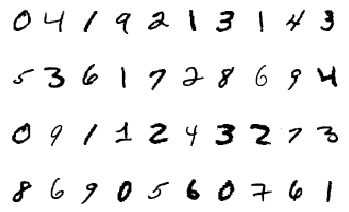

In [4]:
figure = plt.figure()
num_of_images = 40
for index in range(1, num_of_images + 1):
    plt.subplot(4, 10, index)
    plt.axis('off')
    plt.imshow(trainset.data[index], cmap='gray_r')

# Preparing the model

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Declare all the layers for feature extraction
        self.features = nn.Sequential(nn.Conv2d(in_channels=1,
                                                out_channels=5,
                                                kernel_size=3,
                                                stride=1,
                                                padding=1), 
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(in_channels=5,
                                                out_channels=10,
                                                kernel_size=3,
                                                stride=1,
                                                padding=1), 
                                      nn.MaxPool2d(2, 2),
                                      nn.ReLU(inplace=True),
                                      nn.BatchNorm2d(10),
                                      nn.Conv2d(in_channels=10,
                                                out_channels=20,
                                                kernel_size=3,
                                                stride=1,
                                                padding=1),
                                      nn.ReLU(inplace=True),
                                      nn.BatchNorm2d(20),
                                      nn.Conv2d(in_channels=20,
                                                out_channels=40,
                                                kernel_size=3,
                                                stride=1,
                                                padding=1),
                                      nn.MaxPool2d(2, 2),
                                      nn.ReLU(inplace=True),
                                      nn.BatchNorm2d(40))
        
        # Declare all the layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(7 * 7 * 40, 200),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(200, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 10))
        
    def forward(self, x):
      
        # Apply the feature extractor in the input
        x = self.features(x)
        
        # Squeeze the three spatial dimensions in one
        x = x.view(-1, 7 * 7 * 40)
        
        # Classify the images
        x = self.classifier(x)
        return x

## Model architechture

In [6]:
model=Net()
print(model)

Net(
  (features): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU(inplace=True)
    (12): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1960, out_features=200, bias=True)
    (1): ReLU(inplace=True)

## Loss criteria and optimizer

In [7]:
# Instantiate the network
model = Net()

# Instantiate the cross-entropy loss
criterion = nn.CrossEntropyLoss()

# Instantiate the Adam optimizer
optimizer = optim.Adam(model.parameters(),
                       lr = 3e-4,
                       weight_decay= 0.001)

## Model Training

In [8]:
# batch_size, epoch and iteration
batch_size = 100
features_train = trainset.data.shape[0]
n_iters = 6000

num_epochs = n_iters/(features_train/batch_size)                                                                             
num_epochs = int(num_epochs)
num_epochs

10

In [9]:
# CNN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        train, labels = data
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate relu and cross entropy loss
        loss = criterion(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for i, data in enumerate(test_loader, 0):
                test, labels = data
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss value and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 600 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 600  Loss: 0.08807434141635895  Accuracy: 98.0 %
Iteration: 1200  Loss: 0.1078396737575531  Accuracy: 98.5 %
Iteration: 1800  Loss: 0.028495831415057182  Accuracy: 98.80999755859375 %
Iteration: 2400  Loss: 0.04609465226531029  Accuracy: 98.81999969482422 %
Iteration: 3000  Loss: 0.2521807551383972  Accuracy: 98.8499984741211 %
Iteration: 3600  Loss: 0.05365237593650818  Accuracy: 98.88999938964844 %
Iteration: 4200  Loss: 0.0056152124889194965  Accuracy: 98.87999725341797 %
Iteration: 4800  Loss: 0.02556459978222847  Accuracy: 98.75 %
Iteration: 5400  Loss: 0.005236365832388401  Accuracy: 99.0 %
Iteration: 6000  Loss: 0.018330387771129608  Accuracy: 98.97000122070312 %


# Visualize Loss and Accuracy over Iteration

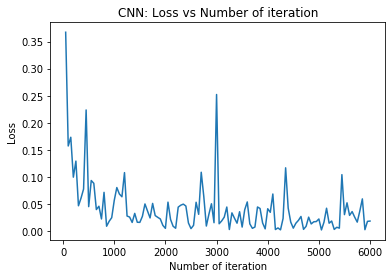

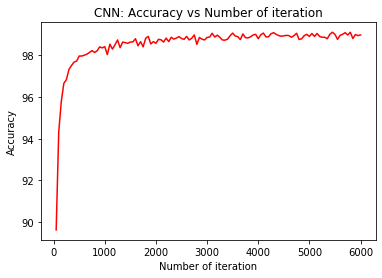

In [10]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()